In [1]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Step 1: Load the dataset
df = pd.read_csv('podcast_dataset.csv')  # Replace with actual path
print("Dataset columns:", df.columns)
print("Unique Publication Days:", df['Publication_Day'].unique())

# Step 2: Filter for Saturday (Đề 6)
df_saturday = df[df['Publication_Day'].str.lower() == 'saturday'].copy()
if df_saturday.empty:
    print("No data for Saturday. Check the dataset or column values.")
    exit()

Dataset columns: Index(['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes', 'Genre',
       'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time',
       'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment',
       'Listening_Time_minutes'],
      dtype='object')
Unique Publication Days: ['Thursday' 'Friday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Saturday']


In [2]:
# Step 3: Prepare the time series data
# Convert to numeric and handle non-numeric values
time_series = pd.to_numeric(df_saturday['Listening_Time_minutes'], errors='coerce').values  # Replace with actual column name
time_series = time_series[~np.isnan(time_series)]  # Remove NaN values
time_series = np.array(time_series).flatten()
print("Shape of time_series:", time_series.shape)
print("First 5 values of time_series:", time_series[:5])

if len(time_series) == 0:
    print("Error: No valid data in time_series after preprocessing.")
    exit()

Shape of time_series: (6800,)
First 5 values of time_series: [57.82734575 81.21341497 31.11030369 68.74       53.37275688]


In [3]:
# Model 1: Basic Kalman Filter
def basic_kalman_filter(data):
    kf = KalmanFilter(
        initial_state_mean=0,
        initial_state_covariance=1,
        observation_covariance=1,
        transition_covariance=0.1
    )
    state_means, state_covariances = kf.filter(data)
    return np.array(state_means).flatten()

# Model 2: Kalman Filter for Time Series (InSAR-inspired)
def kalman_filter_insar(data):
    kf = KalmanFilter(
        initial_state_mean=0,
        initial_state_covariance=1,
        observation_covariance=0.5,
        transition_covariance=0.05,
        transition_matrices=1,
        observation_matrices=1
    )
    state_means, _ = kf.filter(data)
    return np.array(state_means).flatten()

# Model 3: Kalman Smoothing
def kalman_smoothing(data):
    kf = KalmanFilter(
        initial_state_mean=0,
        initial_state_covariance=1,
        observation_covariance=1,
        transition_covariance=0.1,
        n_dim_obs=1  # Explicitly set number of observation dimensions
    )
    # Ensure data is 2D for smooth (n_samples, n_dim_obs)
    data_2d = data.reshape(-1, 1) if data.ndim == 1 else data
    smoothed_state_means, smoothed_state_covariances = kf.smooth(data_2d)
    # Flatten the output to 1D
    return np.array(smoothed_state_means).flatten()

In [4]:
# Step 4: Apply the models
basic_means = basic_kalman_filter(time_series)
insar_means = kalman_filter_insar(time_series)
smoothed_means = kalman_smoothing(time_series)

# Debug: Check shapes and first few values
print("Shape of basic_means:", basic_means.shape)
print("First 5 values of basic_means:", basic_means[:5])
print("Shape of insar_means:", insar_means.shape)
print("First 5 values of insar_means:", insar_means[:5])
print("Shape of smoothed_means:", smoothed_means.shape)
print("First 5 values of smoothed_means:", smoothed_means[:5])

if not (basic_means.ndim == 1 and insar_means.ndim == 1 and smoothed_means.ndim == 1):
    print("Error: One or more arrays are not 1D.")
    exit()

if not (len(time_series) == len(basic_means) == len(insar_means) == len(smoothed_means)):
    print("Error: Arrays have different lengths.")
    print(f"Lengths - time_series: {len(time_series)}, basic_means: {len(basic_means)}, "
          f"insar_means: {len(insar_means)}, smoothed_means: {len(smoothed_means)}")
    exit()

Shape of basic_means: (6800,)
First 5 values of basic_means: [28.91367287 48.52607616 42.91760706 50.58122547 51.3742119 ]
Shape of insar_means: (6800,)
First 5 values of insar_means: [38.55156383 57.06519735 48.03046807 54.43876033 54.12908977]
Shape of smoothed_means: (6800,)
First 5 values of smoothed_means: [44.54811263 47.67500058 47.4480471  48.85486795 48.2731756 ]


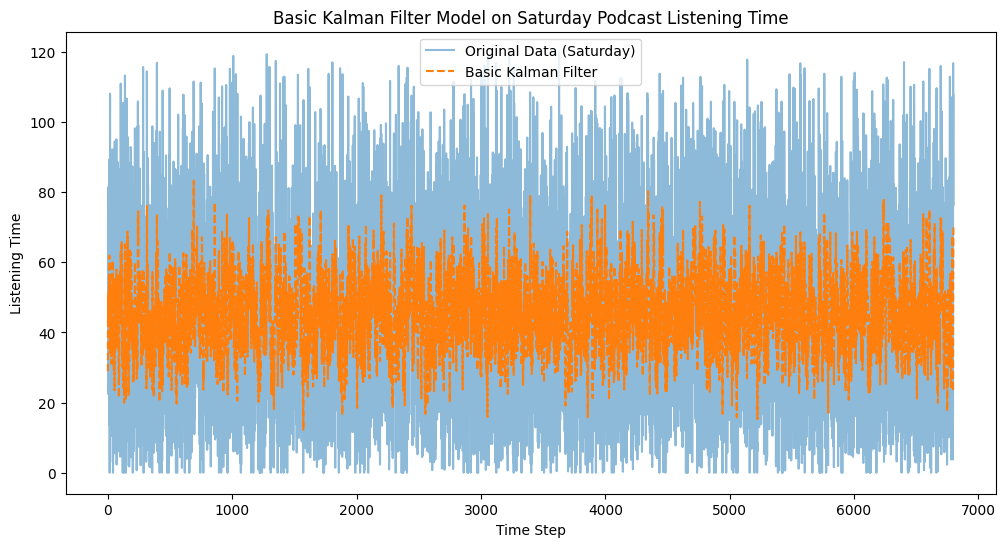

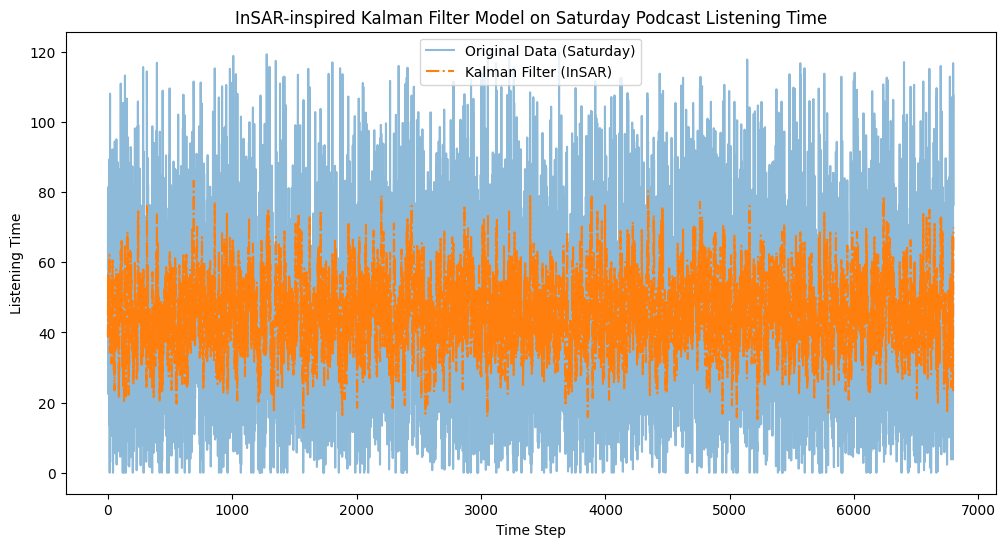

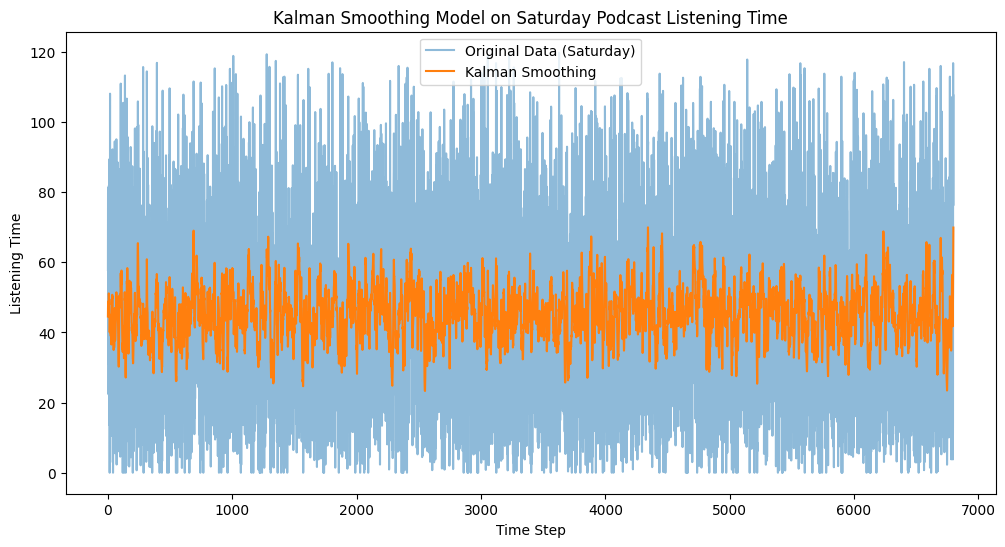

In [5]:
# Step 5: Visualize the results with three separate graphs
# Graph 1: Basic Kalman Filter
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Original Data (Saturday)', alpha=0.5)
plt.plot(basic_means, label='Basic Kalman Filter', linestyle='--')
plt.title('Basic Kalman Filter Model on Saturday Podcast Listening Time')
plt.xlabel('Time Step')
plt.ylabel('Listening Time')
plt.legend()
plt.show()

# Graph 2: InSAR-inspired Kalman Filter
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Original Data (Saturday)', alpha=0.5)
plt.plot(insar_means, label='Kalman Filter (InSAR)', linestyle='-.')
plt.title('InSAR-inspired Kalman Filter Model on Saturday Podcast Listening Time')
plt.xlabel('Time Step')
plt.ylabel('Listening Time')
plt.legend()
plt.show()

# Graph 3: Kalman Smoothing
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Original Data (Saturday)', alpha=0.5)
plt.plot(smoothed_means, label='Kalman Smoothing', linestyle='-')
plt.title('Kalman Smoothing Model on Saturday Podcast Listening Time')
plt.xlabel('Time Step')
plt.ylabel('Listening Time')
plt.legend()
plt.show()

In [6]:
# Step 6: Save results for the report
try:
    results = pd.DataFrame({
        'Original': time_series,
        'Basic_KF': basic_means,
        'InSAR_KF': insar_means,
        'Smoothed_KF': smoothed_means
    })
    results.to_csv('kalman_results_saturday.csv', index=False)
    print("Results saved to 'kalman_results_saturday.csv'.")
except Exception as e:
    print(f"Error saving results: {e}")
    results.to_csv('./output/kalman_results_saturday.csv', index=False)
    print("Results saved to './output/kalman_results_saturday.csv' instead.")

Results saved to 'kalman_results_saturday.csv'.
